In [23]:
!git clone https://github.com/jakeret/unet
!pip install ../working/unet/

fatal: destination path 'unet' already exists and is not an empty directory.
Processing ./unet
  Preparing metadata (setup.py) ... done
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25688 sha256=64f1ff5d9225a22c7d860e8b0a69905f6bd7b1afe1c6a7aa619b971285675a9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lcbju3gd/wheels/5b/07/25/f1d8d63802a7a52409cd462130984a236241d228fb79d44df2
Successfully built unet
  Attempting uninstall: unet
    Found existing installation: unet 0.0.post0.dev81+gf557a51
    Uninstalling unet-0.0.post0.dev81+gf557a51:
      Successfully uninstalled unet-0.0.post0.dev81+gf557a51


In [24]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from unet import utils
from unet.datasets import circles
import unet

In [25]:
training_folder = '../input/cassava-leaf-disease-classification/train_images/'
samples_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
samples_df["label"] = samples_df["label"].astype("str")
samples_df.head(10)

image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1
3  1000723321.jpg     1
4  1000812911.jpg     3
5  1000837476.jpg     3
6  1000910826.jpg     2
7  1001320321.jpg     0
8  1001723730.jpg     4
9  1001742395.jpg     3

In [26]:
samples_df = samples_df.query("label=='4'")

In [27]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [28]:
def get_ECI_band(img):
    '''
    Return the ECI band calculated from an RGB image between 0 and 255
    using the formula below:    
    ECI = (red_channel-1)^2 + green_channel^2/0.16
    '''
    img = img/255.
    img = cv2.GaussianBlur(img,(35,35),0)
    ECI_band = np.power(img[:,:,0]-1,2) + np.power(img[:,:,1],2)/0.16
    normalized_ECI_band = (ECI_band/ECI_band.max()*255).astype(np.uint8)
    return normalized_ECI_band


def get_CIVE_band(img):
    '''
    Return the CIVE band calculated from an RGB image between 0 and 255
    using the formula below:
    CIVE = 0.441*red_channel - 0.881*green_channel + 0.385*blue_channel + 18.787
    '''
    img = cv2.GaussianBlur(img,(35,35),0)
    CIVE_band = 0.441*img[:,:,0] - 0.881*img[:,:,1] + 0.385*img[:,:,2] + 18.787
    normalized_CIVE_band = (((CIVE_band+abs(CIVE_band.min()))/CIVE_band.max())).astype(np.uint8)
    return normalized_CIVE_band


def apply_ECI_mask(img, vegetation_index_band):
    '''
    Apply a binary mask on an image and return the masked image
    '''
    ret, otsu = cv2.threshold(vegetation_index_band,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masked_img = cv2.bitwise_and(img,img,mask = otsu)
    return masked_img


def apply_CIVE_mask(img, vegetation_index_band):
    '''
    Apply a binary mask on an image and return the masked image
    '''
    ret, otsu = cv2.threshold(vegetation_index_band,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    masked_img = cv2.bitwise_and(img,img,mask = otsu)
    return masked_img

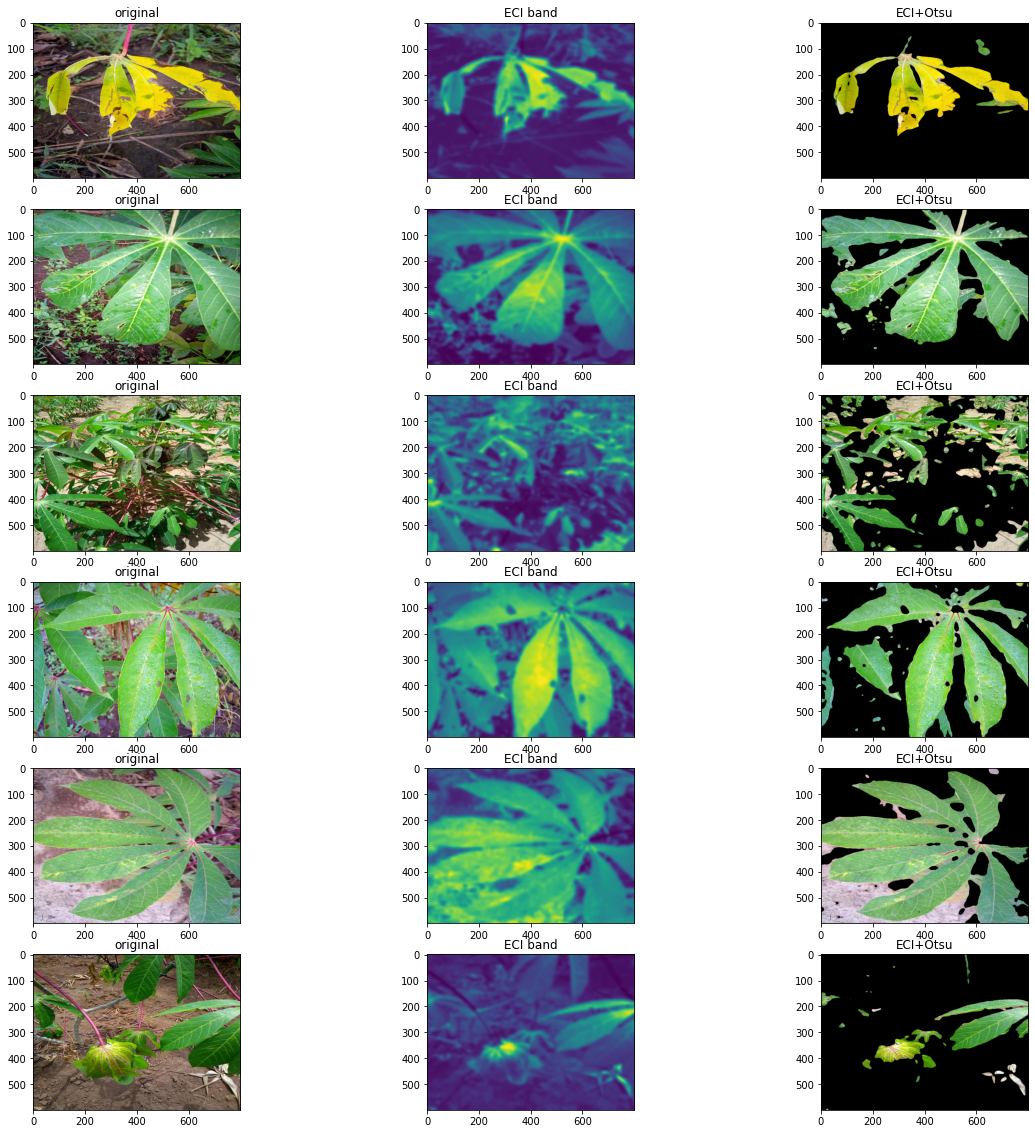

In [29]:
plt.figure(figsize=(20, 20))
items = 6
for idx, image_id in enumerate(samples_df.image_id[:items]):
    img_path = training_folder+image_id
    img = np.array(Image.open(img_path))
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    ECI_band =  get_ECI_band(img)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("ECI band")
    plt.imshow(ECI_band)
    
    masked_img = apply_ECI_mask(img, ECI_band)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("ECI+Otsu")
    plt.imshow(masked_img)

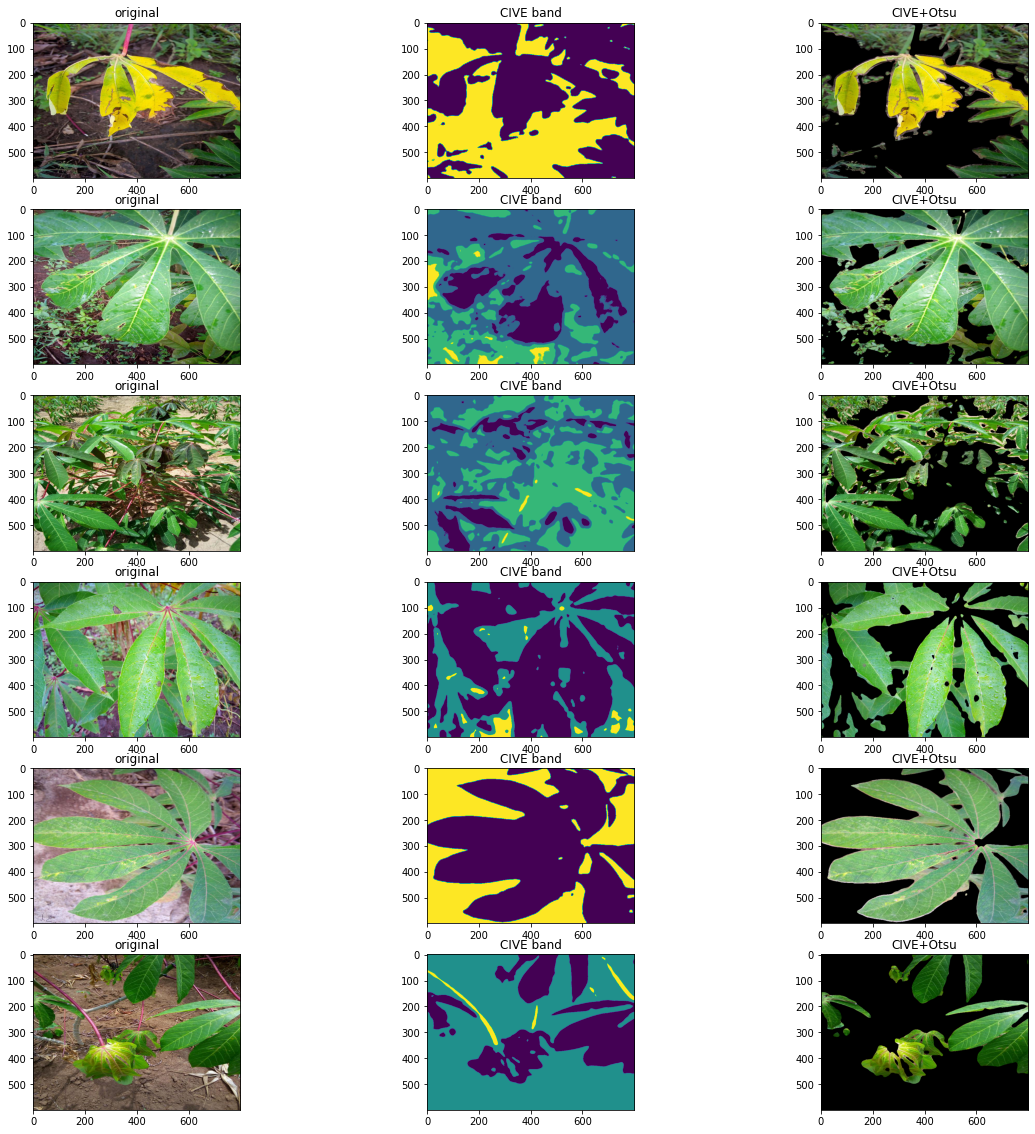

In [30]:
plt.figure(figsize=(20, 20))
items = 6
for idx, image_id in enumerate(samples_df.image_id[:items]):
    img_path = training_folder+image_id
    img = np.array(Image.open(img_path))
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    CIVE_band = get_CIVE_band(img)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("CIVE band")
    plt.imshow(CIVE_band)
    
    masked_img = apply_CIVE_mask(img, CIVE_band)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("CIVE+Otsu")
    plt.imshow(masked_img)

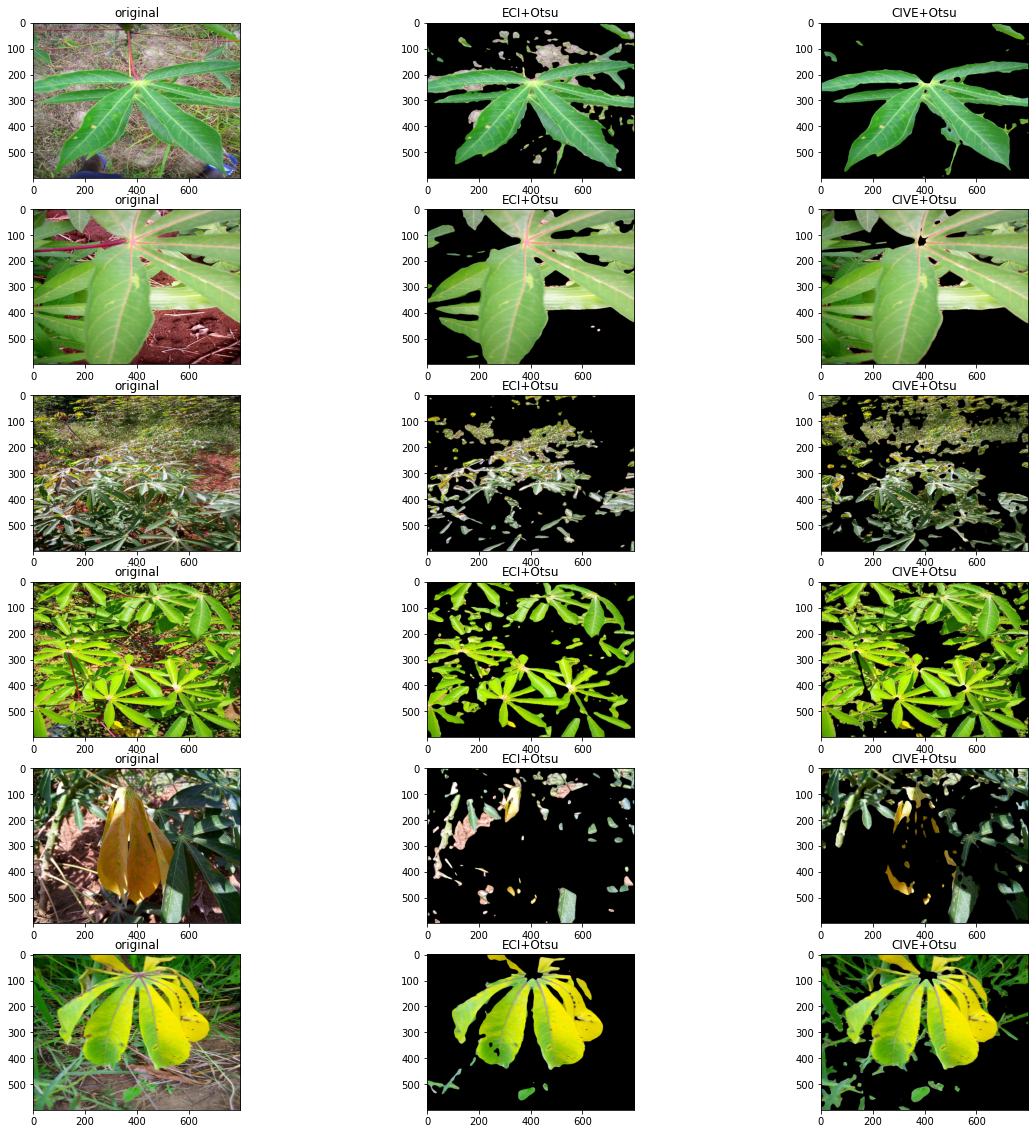

In [31]:
plt.figure(figsize=(20, 20))
items = 6
for idx, image_id in enumerate(samples_df.image_id[10:10+items]):
    img_path = training_folder+image_id
    img = np.array(Image.open(img_path))
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    ECI_band =  get_ECI_band(img)
    CIVE_band = get_CIVE_band(img)

    masked_img = apply_ECI_mask(img, ECI_band)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("ECI+Otsu")
    plt.imshow(masked_img)
    
    masked_img = apply_CIVE_mask(img, CIVE_band)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("CIVE+Otsu")
    plt.imshow(masked_img)

In [32]:
def get_input_image(img_path, crop_size=512):
    '''
    Randomly select a 512x512 pixel area from the full image
    '''
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)
    cropped_img = img[x:x+crop_size , y:y+crop_size,:]
    
    return cropped_img


def get_groundtruth_mask(img, crop_size=512):
    '''
    Generate the groundtruth mask using the CIVE band
    '''
    img = cv2.GaussianBlur(img,(35,35),0)
    cive_band = 0.441*img[:,:,0] - 0.881*img[:,:,1] + 0.385*img[:,:,2] + 18.787
    normalized_cive_band = (((cive_band+abs(cive_band.min()))/cive_band.max())).astype(np.uint8)
    ret, otsu_mask = cv2.threshold(normalized_cive_band,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    veg_mask = otsu_mask.astype(np.uint8)
    soil_mask = np.where(otsu_mask==1, 0, 1).astype(np.uint8)
    masks = np.transpose(np.array([soil_mask, veg_mask]),(1,2,0))
    
    return masks

In [33]:
augmentation = iaa.Sequential([
    iaa.Multiply((0.5, 1.5)),
    iaa.Affine(scale={"x": (1, 1.2), "y":(1, 1.2)}),
    iaa.Sometimes(0.4,
                 iaa.GaussianBlur(sigma=(0,2))),
    iaa.Sometimes(0.3,
                 iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.3,
                 iaa.SigmoidContrast(gain=(3, 6), cutoff=(0.4, 0.6))),
    iaa.Sometimes(0.3,
        iaa.CoarseDropout((0.0, 0.05), size_percent=(0.05, 0.6), per_channel=0.5))
])

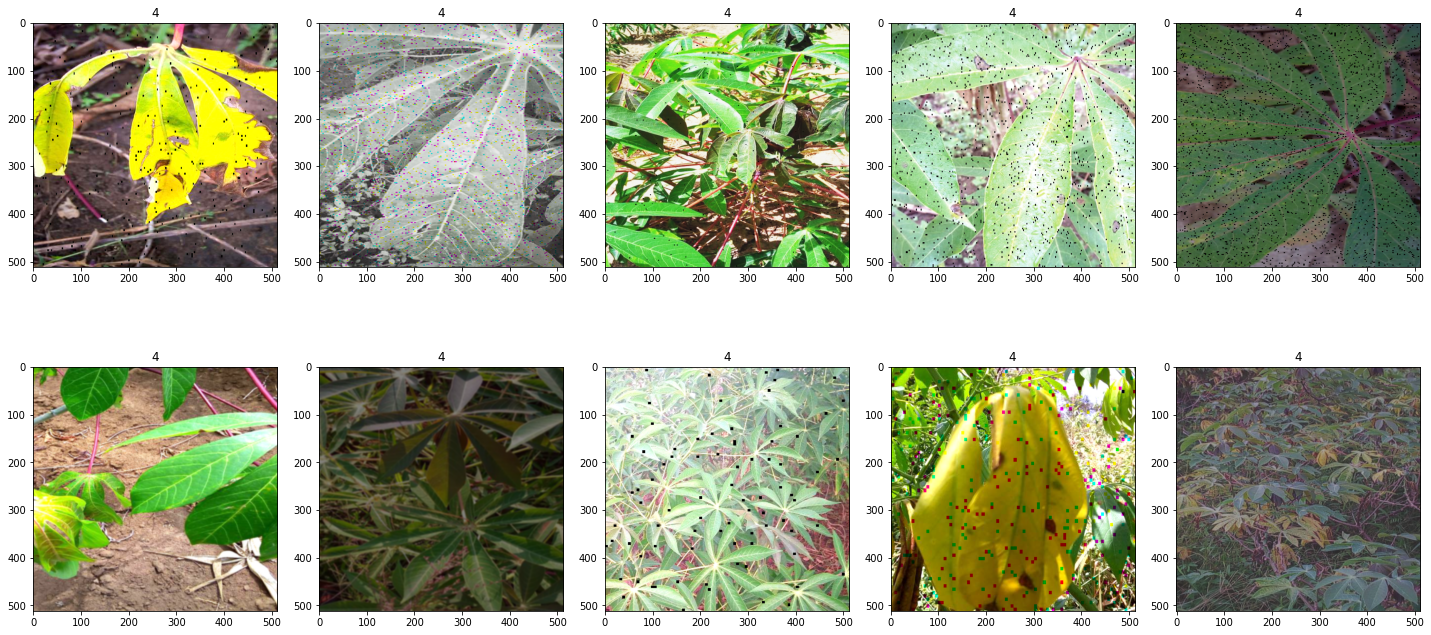

In [34]:
images = [get_input_image(training_folder+image_filename) for image_filename in samples_df[:10].image_id.values]
labels = samples_df[:10].label.values
augmented_images = augmentation.augment_images(images=images)

sample_number = len(augmented_images)
fig = plt.figure(figsize = (20,sample_number))
for i in range(0,sample_number):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(augmented_images[i])
    ax.set_title(str(labels[i]))
plt.tight_layout()
plt.show()

In [35]:
def custom_generator(image_path_list, folder, batch_size=16, training_mode=True):
    
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch = []
            Y_batch = []
            end = min(start + batch_size, training_item_count)
            
            image_list = [get_input_image(folder+"/"+image_path) for image_path in image_path_list[start:end]]
            groundtruth_image_list = [get_groundtruth_mask(image) for image in image_list]
            
            #only apply augmentation during training
            if training_mode:
                image_list = augmentation.augment_images(images=image_list)

            X_batch = np.array(image_list)/255.
            Y_batch = np.array(groundtruth_image_list)

            yield X_batch, Y_batch

In [36]:
batch_size = 8
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [37]:
unet_model = unet.build_model(512,
                              channels=3,
                              num_classes=2,
                              layer_depth=4,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model,
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.BinaryAccuracy()],
                    auc=False,
                    learning_rate=1e-4)

In [40]:
history = unet_model.fit_generator(custom_generator(training_df["image_id"], training_folder, batch_size=batch_size, training_mode=True),
                  steps_per_epoch = int(len(training_df)/batch_size),
                  epochs = 20, 
                  validation_data=custom_generator(validation_df["image_id"], training_folder, batch_size=batch_size),
                  validation_steps=int(len(validation_df)/batch_size),
                  callbacks=callbacks)

Epoch 1/20
 14/257 [>.............................] - ETA: 8:22:14 - loss: 0.6880 - binary_accuracy: 0.5402 - mean_iou: 0.3274 - dice_coefficient: 0.5117

KeyboardInterrupt: 

In [ ]:
unet_model.load_weights("best_model.h5")

In [ ]:
!cat ../input/cassava-leaf-disease-classification/label_num_to_disease_map.json

In [ ]:
training_folder = '../input/cassava-leaf-disease-classification/train_images/'
disease_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
disease_df = disease_df.query("label!=4")

In [ ]:
plt.figure(figsize=(20, 20))
items = 5
for idx, image_id in enumerate(validation_df.image_id[:items]):
    img_path = training_folder+image_id
    img = get_input_image(img_path)
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    CIVE_band = get_CIVE_band(img)
    masked_img = apply_CIVE_mask(img, CIVE_band)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("CIVE+Otsu")
    plt.imshow(masked_img)

    mask = unet_model.predict(np.array([img]))
    soil_mask = np.where(np.transpose(mask[0],(2,0,1))[0]<=0.5,1,0).astype(np.uint8)
    masked_img = cv2.bitwise_and(img,img,mask = soil_mask)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("Unet")
    plt.imshow(masked_img)

In [ ]:
plt.figure(figsize=(20, 20))
items = 5
for idx, image_id in enumerate(disease_df.image_id[10:10+items]):
    img_path = training_folder+image_id
    img = get_input_image(img_path)
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    CIVE_band = get_CIVE_band(img)
    masked_img = apply_CIVE_mask(img, CIVE_band)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("CIVE+Otsu")
    plt.imshow(masked_img)

    mask = unet_model.predict(np.array([img]))
    soil_mask = np.where(np.transpose(mask[0],(2,0,1))[0]<=0.5,1,0).astype(np.uint8)
    masked_img = cv2.bitwise_and(img,img,mask = soil_mask)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("Unet")
    plt.imshow(masked_img)